In [ ]:
# !pip install gensim
# !pip install scipy==1.12
# !pip install stop-words
# !pip install torch
# !pip install transformers
# !pip install scikit-learn
# !pip install nltk


In [80]:
import pandas as pd
# from tqdm.notebook import tqdm as tqdm_notebook
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
import seaborn as sns
import gensim
import copy
import time
import numpy as np
import torch
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import nltk
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from nltk.tokenize import RegexpTokenizer


# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = stopwords.words('russian')
stop_words.extend(['доброго', 'времени', 'суток'])

%matplotlib inline

## LABSE vectorization

In [43]:
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained("cointegrated/LaBSE-en-ru")
model = AutoModel.from_pretrained("cointegrated/LaBSE-en-ru")

## RUBERT vectorization

In [13]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

sentences = ["Привет, как дела?", "Машинное обучение очень интересно!"]

inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

# Get the BERT embeddings
with torch.no_grad():
    outputs = model(**inputs)

# outputs['last_hidden_state'] contains the token-level embeddings for each word
token_embeddings = outputs.last_hidden_state  # (batch_size, sequence_length, hidden_size)

cls_embeddings = token_embeddings[:, 0, :]  # (batch_size, hidden_size)
cls_embeddings = torch.nn.functional.normalize(cls_embeddings, p=2, dim=1)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum lengt

In [4]:
df = pd.read_csv('tickets_2.csv',
                 sep=';',
                 encoding='windows-1251')

In [41]:
df.head()

,start_dt,end_dt,sender_name,sender_email,theme,descr,sentences
0,2023-01-01 08:22:15+00,2023-01-01 19:14:50+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20595877,. Доброго времени суток! ПРОСЬБА ПРИ ОТВЕТЕ НА...,просьба ответе запрос использьзовать функцию о...
1,2023-01-01 11:18:47+00,2023-01-01 19:18:36+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20592639,"Доброго времени суток! Абонент утверждает, что...",абонент утверждает заказывал просим проверить ...
2,2023-01-01 12:31:00+00,2023-01-01 18:52:48+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20594559,"Доброго времени суток! Абонент утверждает, что...",абонент утверждает заказывал просим проверить ...
3,2023-01-01 13:15:12+00,2023-01-01 18:51:01+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20593507,"Доброго времени суток! Абонент утверждает, что...",абонент утверждает заказывал просим проверить ...
4,2023-01-01 13:15:12+00,2023-01-01 18:52:00+00,content_problem,content_problem@tele2.ru,Жалоба абонента TT20593899,"Доброго времени суток! Абонент утверждает, что...",абонент утверждает заказывал просим проверить ...


In [34]:
tokenizer = RegexpTokenizer(r'\w+')

def preprocess(text):
    tokens = ' '.join(tokenizer.tokenize(text))

    return ' '.join([word for word in tokens.lower().split() if word not in stop_words])

# Clustering analysis

Для векторизации текста использовалась модель LaBSE от @cointegrated.
Подберем количество кластеров

In [35]:
df['sentences'] = df['descr'].astype(str) + df['theme'].astype(str)

In [40]:
df.sentences = df.sentences.astype(str).apply(lambda x: preprocess(x))

In [44]:
embeddings_list = []

for s in df.sentences:
    encoded_input = tokenizer(s, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**encoded_input)
    embedding = model_output.pooler_output
    embeddings_list.append((embedding)[0].numpy())


df['embeddings'] = embeddings_list
# df.to_csv('out.csv', index=False)

In [ ]:
torch.nn.functional.normalize(embeddings_list, p=2, dim=1)

In [13]:
# df = pd.read_csv('out.csv')
# embeddings_list = df['embeddings'].astype('float').to_list()
# embeddings = np.asarray(embeddings_list)

In [68]:
embeddings = np.asarray(embeddings_list)

## KMeans

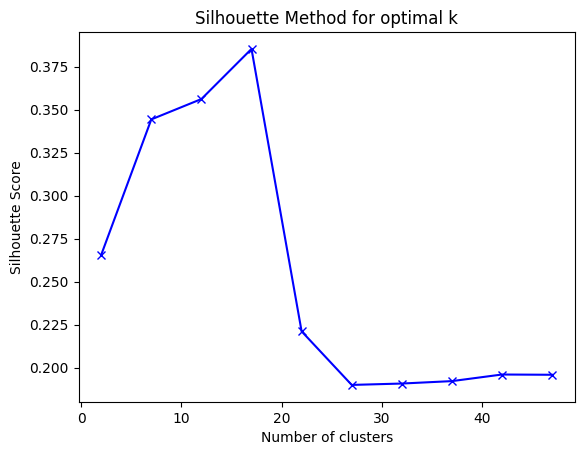

In [48]:
# Подберем количество кластеров

k_values = [x for x in range(2, 50, 5)]

silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=100).fit(embeddings)
    score = silhouette_score(embeddings, kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for optimal k')
plt.show()

In [51]:
kmeans = KMeans(n_clusters = 17, random_state = 100500).fit(embeddings)
kmeans_labels = kmeans.labels_

kmeans.cluster_centers_ = kmeans.cluster_centers_.astype(np.float32)

In [52]:
data = pd.DataFrame()
data['text'] = df.sentences
data['label'] = kmeans_labels
data['embedding'] = list(embeddings)

In [53]:
ypred = kmeans.predict(embeddings)

In [63]:
top_texts_list = []
for i in range (0, k):
    cluster = data[data['label'] == i]
    embeddings = list(cluster['embedding'])
    texts = list(cluster['text'])
    distances = [euclidean_distances(kmeans.cluster_centers_[0].reshape(1, -1), e.reshape(1, -1))[0][0] for e in embeddings]
    scores = list(zip(texts, distances))
    top_5 = sorted(scores, key=lambda x: x[1])[:5]
    top_texts = list(zip(*top_5))
    top_texts_list.append(top_texts)

In [88]:
top_texts_list[0]

[('абонент утверждает заказывал просим проверить корректность списаний рассмотреть вопрос компенсации просьба отключить абоненту подписки удали лишнюю информацию 0 номер котором подключены подписки 79504593733 1 b2c дата время подключения подписок b2b дата время которой необходимо скорректировать денежные средства 28 11 2022 2 номер провайдера дс invoice ро жалоба абонента tt21681531',
  'абонент утверждает заказывал просим проверить корректность списаний рассмотреть вопрос компенсации просьба отключить абоненту подписки удали лишнюю информацию 0 номер котором подключены подписки 79536410053 1 b2c дата время подключения подписок b2b дата время которой необходимо скорректировать денежные средства 29 10 2022 2 номер провайдера дс invoice розницы номер п жалоба абонента tt21071288',
  'абонент утверждает заказывал просим проверить корректность списаний рассмотреть вопрос компенсации просьба отключить абоненту подписки удали лишнюю информацию 0 номер котором подключены подписки 79049091840

In [62]:
data.groupby('label')['label'].sum()

label
0         0
1       741
2       488
3      1932
4      1088
5      2005
6      1008
7      1253
8      2704
9      2187
10     2350
11    37488
12     5340
13     3705
14     7840
15    14835
16     8944
Name: label, dtype: int32

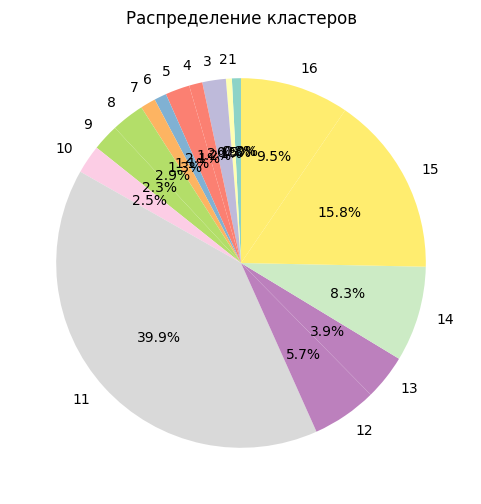

In [64]:
label_counts = data.groupby('label')['label'].sum()

# Plot a pie chart
plt.figure(figsize=(6, 6)) 
label_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='Set3')
plt.ylabel('')
plt.title('Распределение кластеров')
plt.show()

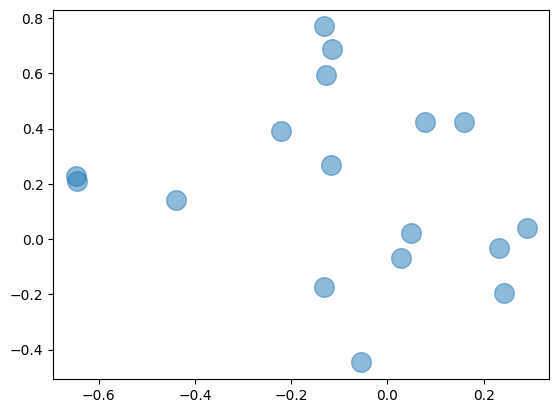

In [65]:
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, alpha=0.5);

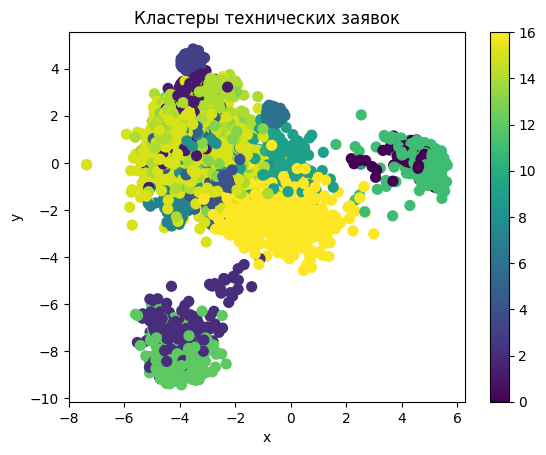

In [70]:
# Reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plotting
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=ypred, s=50)
plt.colorbar()  # Optional: Add color bar to see the mapping of colors to classes
plt.xlabel('x')
plt.ylabel('y')
plt.title('Кластеры технических заявок')
plt.show()

In [ ]:
# t-SNE для визуализации
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(embeddings)

# Визуализация кластеров
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=ypred, cmap='rainbow')
plt.show()

Посмотрим примеры кластеров

In [71]:
data[data['label'] == 10]

,text,label,embedding
60,добрый день 9066436900 номер абонента клиент п...,10,"[-0.40088165, 0.79691994, 0.43555245, -0.42261..."
85,добрый день 9656821199 номер абонента клиент п...,10,"[-0.11009726, 0.8339729, 0.29549578, -0.302741..."
107,добрый день 9672192653 номер абонента клиент п...,10,"[-0.15730794, 0.8213874, 0.34737575, -0.396842..."
245,добрый день номер абонента 9624372369 клиент п...,10,"[-0.05668693, 0.61862224, 0.34370002, -0.46995..."
247,добрый день просим отключить рассылку c номера...,10,"[-0.23437954, 0.63081294, 0.12228644, 0.048368..."
...,...,...,...
6980,добрый день 9039236765 номер абонента клиент п...,10,"[-0.42805988, 0.6233488, 0.5602243, -0.1200862..."
6981,добрый день 9642729197 номер абонента клиент п...,10,"[-0.2572173, 0.75813645, 0.6325848, 0.19383635..."
6982,добрый день 9659552730 номер абонента клиент п...,10,"[-0.061937507, 0.762133, 0.4272865, 0.03234385..."
7026,добрый день 9643431962 номер абонента клиент п...,10,"[-0.04746965, 0.82943726, 0.5101764, -0.492677..."


In [72]:
data[data['label'] == 9]

,text,label,embedding
11,добрый день коллеги поступила жалоба абонента ...,9,"[0.42672065, 0.28433403, -0.23292184, -0.04777..."
61,добрый день коллеги поступила жалоба абонента ...,9,"[-0.025632834, 0.23142572, -0.28669524, -0.310..."
96,добрый день коллеги поступила жалоба абонента ...,9,"[0.03287166, 0.5997343, -0.22134167, -0.124170..."
218,добрый день коллеги поступила жалоба абонента ...,9,"[0.16836207, 0.44871342, -0.17588745, -0.10052..."
286,добрый день коллеги поступила жалоба абонента ...,9,"[0.09822846, 0.5103413, -0.1568544, -0.0067253..."
...,...,...,...
9879,добрый день уважаемые коллеги поступила жалоба...,9,"[-0.25489762, 0.23703943, -0.5326971, -0.35858..."
9880,добрый день уважаемые коллеги поступила жалоба...,9,"[-0.24530186, 0.5099981, -0.28012702, -0.35312..."
9997,живой баланс 2 0 0 номер абонента 79522354555 ...,9,"[-0.19048853, 0.7350453, 0.36022094, 0.0483033..."
9998,живой баланс 2 0 0 номер абонента 79522354555 ...,9,"[-0.19970162, 0.7486897, 0.3807401, 0.05964608..."


In [76]:
num_clusters = 17
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df.sentences)

# Get the feature names (words)
terms = tfidf_vectorizer.get_feature_names_out()

# Assign sentences to clusters
clusters = {i: [] for i in range(num_clusters)}

for i, label in enumerate(data.label):
    clusters[label].append(i)

In [77]:
def get_top_keywords(cluster_sentences, top_n=5):
    cluster_tfidf = tfidf_matrix[cluster_sentences].mean(axis=0).flatten()
    sorted_indices = cluster_tfidf.argsort()[::-1]  # Sort in descending order
    top_terms = [terms[idx] for idx in sorted_indices[:top_n]]
    return top_terms

# Print top words for each cluster
for cluster, sentences_in_cluster in clusters.items():
    print(f"Cluster {cluster} Top Keywords: {get_top_keywords(sentences_in_cluster)}\n")

Cluster 0 Top Keywords: [array([['ёлкой', 'tt20889081', 'tt20889179', ..., 'информацию', 'лишнюю',
        'удали']], dtype=object)]

Cluster 1 Top Keywords: [array([['79536617919', 'tt20967724', 'tt20967976', ..., 'плановых', '00',
        'оператора']], dtype=object)]

Cluster 2 Top Keywords: [array([['00', 'tt20928980', 'tt20929732', ..., 'письмо', 'канал', 'это']],
      dtype=object)]

Cluster 3 Top Keywords: [array([['00', 'tt21127033', 'tt21127374', ..., 'активные', 'навсегда',
        '99993']], dtype=object)]

Cluster 4 Top Keywords: [array([['79536617919', 'tt21197855', 'tt21199245', ..., 'наименование',
        'заявки', 'esim']], dtype=object)]

Cluster 5 Top Keywords: [array([['79536617919', 'tt21053929', 'tt21054646', ..., 'access',
        'vimpelcom', 'provider']], dtype=object)]

Cluster 6 Top Keywords: [array([['00', 'tt21127374', 'tt21127526', ..., 'номера', 'ums',
        'отключенные']], dtype=object)]

Cluster 7 Top Keywords: [array([['00', 'tt21085200', 'tt210857

## DBSCAN

In [85]:
# Нормализация данных перед кластеризацией
scaler = StandardScaler()
data_scaled = scaler.fit_transform(embeddings)

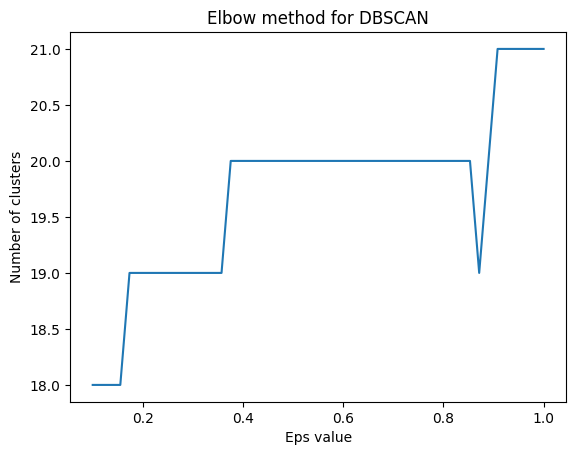

In [86]:
# Диапазон значений для eps
eps_values = np.linspace(0.1, 1.0, 50)
num_clusters = []

for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(embeddings)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    num_clusters.append(n_clusters)

# Uрафик зависимости количества кластеров от значения eps
plt.plot(eps_values, num_clusters)
plt.xlabel("Eps value")
plt.ylabel("Number of clusters")
plt.title("Elbow method for DBSCAN")
plt.show()

In [89]:
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(embeddings)

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f'Найдено {n_clusters} кластеров (включая шум)')

Найдено 19 кластеров (включая шум)


C:\Users\Администратор\AppData\Local\Temp\ipykernel_10896\2177512060.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1', len(unique_labels))


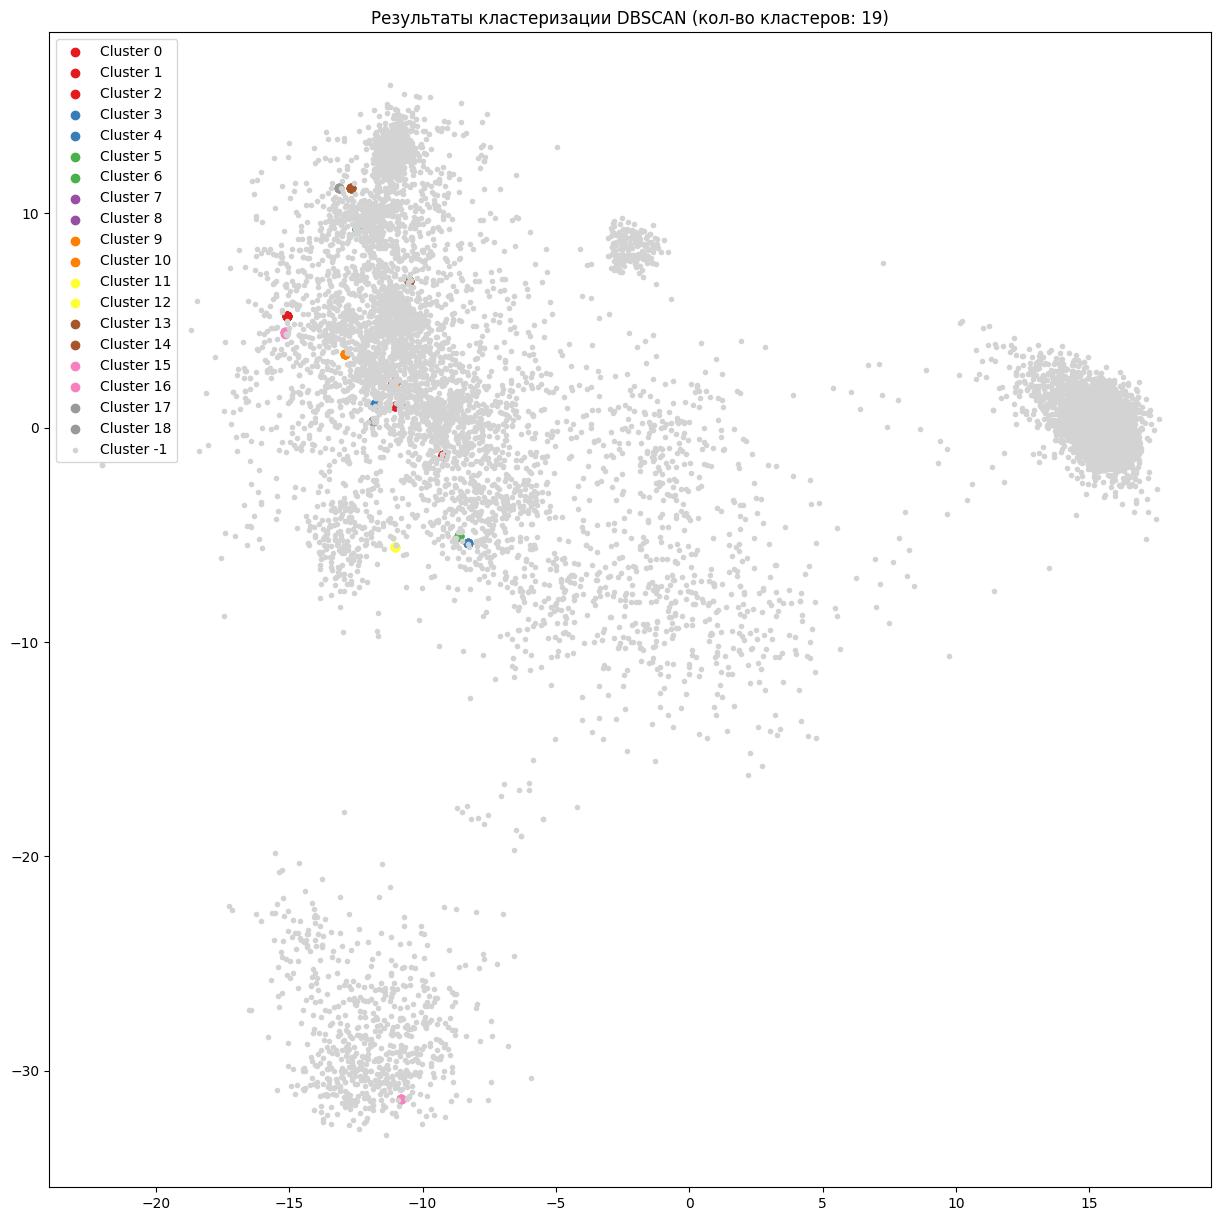

In [92]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Визуализация результатов
plt.figure(figsize=(15, 15))
unique_labels = set(labels)
colors = plt.cm.get_cmap('Set1', len(unique_labels))

for label in unique_labels:
    if label == -1:
        color = 'lightgrey'
        marker = '.'
        label_name = 'Noise'
    else:
        color = colors(label)
        marker = 'o'
    
    plt.scatter(data_pca[labels == label, 0], data_pca[labels == label, 1], 
                c=[color], label=f'Cluster {label}', marker=marker)

plt.title(f'Результаты кластеризации DBSCAN (кол-во кластеров: {n_clusters})')
plt.legend()
plt.show()